2016 notebook downloaded [from here](http://nbviewer.jupyter.org/github/amrhein/freshwaterhack/blob/master/grace_wells.ipynb)

In [8]:
%matplotlib inline
%qtconsole

import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.basemap import Basemap
import plotly.plotly as py
py.sign_in('ctasich', 'fpoe1n01ek')

from datetime import datetime, timedelta
from scipy import stats

In [3]:
## Load Data

# GRACE data
nc = 'http://opendap.jpl.nasa.gov:80/opendap/GeodeticsGravity/tellus/L3/mascon/RL05/JPL/CRI/netcdf/GRCTellus.JPL.200204_201606.GLO.RL05M_1.MSCNv02CRIv02.nc'
grace = xr.open_dataset(nc)

# Well data
csv = 'https://www.hydroshare.org/django_irods/download/d3659dcf575d4090801a74d1ce096d7c/data/contents/WPDx_Well_Function_Upd_151224_xy161117.csv'
wells = pd.read_csv(csv)

In [4]:
## Preprocess data

## Wells
wells['color'] = np.where(wells['FUNC']=='Yes', '#2ECC71', '#E74C3C')

## GRACE
rmap = grace['lwe_thickness'][0,:,:]

# Extract Lat/Lon Metadata
lat_min = grace.geospatial_lat_min
lat_max = grace.geospatial_lat_max
lat_res = float(grace.geospatial_lat_resolution[0:3])

lon_min = grace.geospatial_lon_min
lon_max = grace.geospatial_lon_max
lon_res = float(grace.geospatial_lon_resolution[0:3])

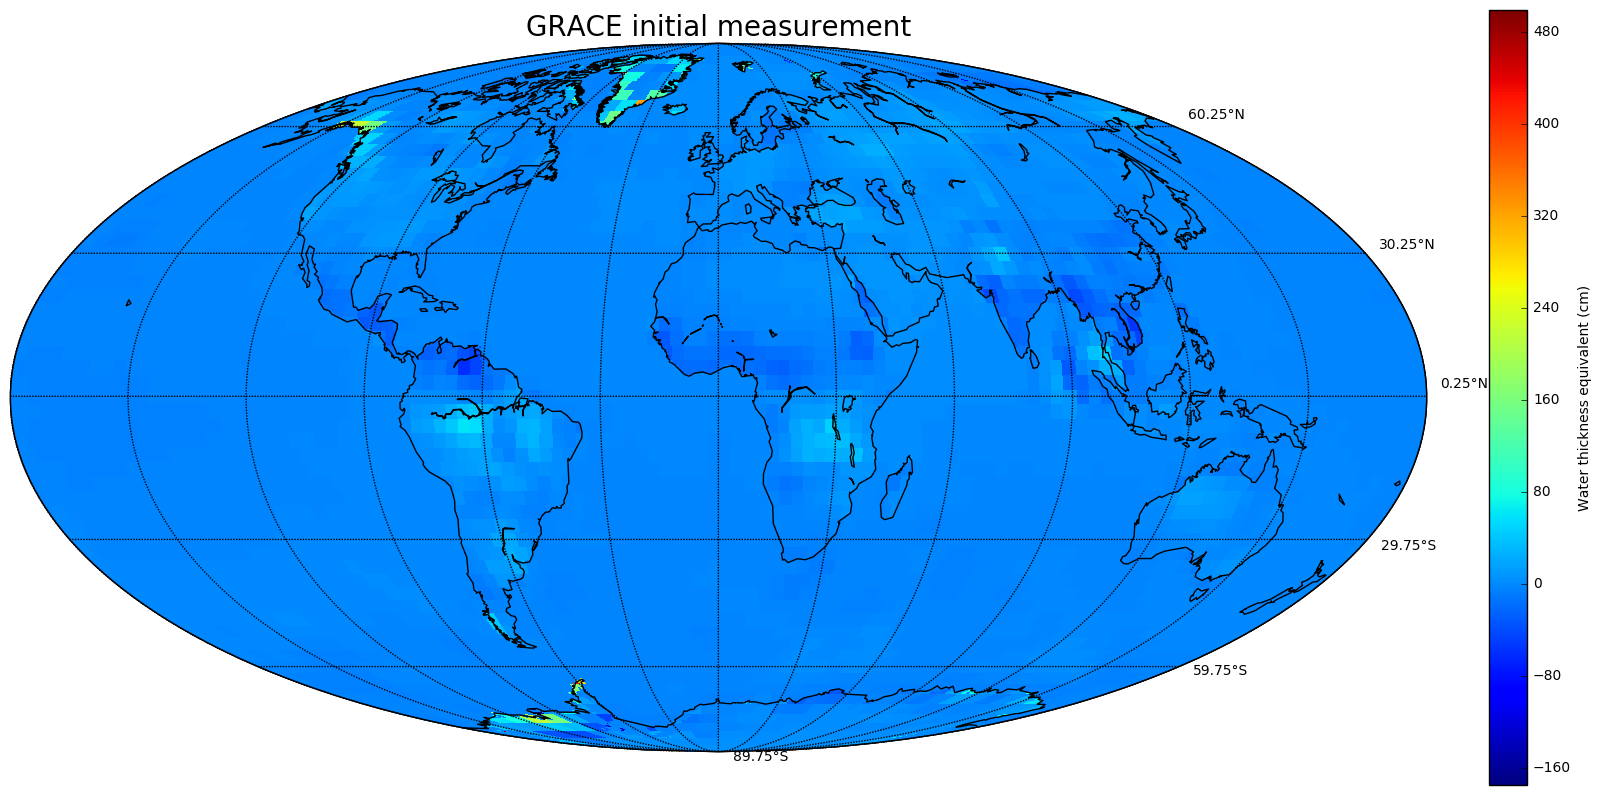

In [6]:
## Plot GRACE data

# Build grid
lon_g = np.arange(lon_min,lon_max+lon_res,lon_res)
lat_g = np.arange(lat_min,lat_max+lat_res,lat_res)
x,y = np.meshgrid(lon_g[:], lat_g[:])

# Plot Fig
plt.figure(figsize=(20,10))
m = Basemap(projection='moll',llcrnrlat=-87,urcrnrlat=81,lon_0=0,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw parallels and meridians.
parallels = np.arange(-89.75,89.75,30.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[False,True,True,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,30.)
m.drawmeridians(meridians)
m.drawmapboundary(fill_color='white')

ax = plt.gca()
masked_array = np.ma.array(rmap, mask=np.isnan(rmap))
cmap = matplotlib.cm.jet
cmap.set_bad('white',1.0)

im1 = m.pcolormesh(x,y,rmap,shading='flat',latlon=True);
im2 = m.pcolormesh(x,y,masked_array,shading='flat',latlon=True)
m.drawcoastlines();
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Water thickness equivalent (cm)')
plt.title('GRACE initial measurement',size=20);

In [9]:
## Plot well data in plotly

data = [ dict(
    lat = wells.LAT_DD,
    lon = wells.LONG_DD,
    marker = dict(
        color = wells.color.tolist(),
        opacity = 0.7,
        size = 2,                
    ),
    type = 'scattergeo'
) ]

layout = dict(
    geo = dict(showland = True,
        landcolor = "rgb(212, 212, 212)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = True,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        resolution = 10,
        projection = dict(
            type = 'utm'),
        lonaxis = dict(
            showgrid = True,
            gridwidth = 0.5,
            range= [ -20, 80 ],
            dtick = 5
        ),
        lataxis = dict (
            showgrid = True,
            gridwidth = 0.5,
            range= [ -20, 40 ],
            dtick = 5
        )
    ),
    title = 'Wells from WPDx',
)
fig = { 'data':data, 'layout':layout }
py.iplot(fig, filename='wells')

In [6]:
# Code that subselects regions of interest. This is for all of Africa, but will be used later to get individual time series

data = xr.open_dataset('http://opendap.jpl.nasa.gov:80/opendap/GeodeticsGravity/tellus/L3/mascon/RL05/JPL/CRI/netcdf/GRCTellus.JPL.200204_201606.GLO.RL05M_1.MSCNv02CRIv02.nc')

af = xr.concat( [data['lwe_thickness'].sel(lat=slice(-37.75,37.75)).sel(lon=slice(340.25,359.75)),
                  data['lwe_thickness'].sel(lat=slice(-37.75,37.75)).sel(lon=slice(0.25,50.75))],
                  dim='lon')

lonaf = xr.concat( [data['lon'].sel(lon=slice(340.25,359.75)),
                  data['lon'].sel(lon=slice(0.25,50.75))],
                  dim='lon')

lataf = data['lat'].sel(lat=slice(-37.75,37.75))


In [7]:
# Find nearest grid locations for all data
# lon_g and lat_g are the lons and lats of the gridded products, respectively
# nb this is only for Africa for now! Change things in the previous cell if you want to deal with the global GRACE dataset.

lon_g = lonaf
lat_g = lataf

xRes = np.median(np.diff(lon_g))
yRes = np.median(np.diff(lat_g))

# Define grid box centers
lon_c = lon_g[:-1]+xRes/2
lat_c = lat_g[:-1]+yRes/2

# Define a new metadata file that has grid coordinates for this resolution choice
wg = wells

wg.loc[:,'grid_lat'] = np.nan
wg.loc[:,'grid_lon'] = np.nan
wg.loc[:,'grace_mean'] = np.nan
wg.loc[:,'grace_std'] = np.nan
wg.loc[:,'grace_at_rpt_date'] = np.nan

## Determine grid_lat and grid_lon for every record

for index, row in wg.iterrows():
    lon_s = row[u'LONG_DD']
    lat_s = row[u'LAT_DD']
    # correct for wrapping
    if lon_s<0:
        lon_s = 360+lon_s
    glat = lat_g.values[np.argmin(np.abs(lat_c.values-lat_s))]
    glon = lon_g.values[np.argmin(np.abs(lon_c.values-lon_s))]
    wg.set_value(index,'grid_lat',glat)
    wg.set_value(index,'grid_lon',glon)

# Get all unique grid_lat and grid_lon pairs. Don't totally understand this bit of magic...
allpairs = wg[['grid_lat', 'grid_lon']].values
upairs = np.array(list(set(tuple(p) for p in allpairs)))

# GRACE at well locations. sel_points is necessary to get coordinate pairs.
wellG = data['lwe_thickness'].sel_points(lat=upairs[:,0],lon=upairs[:,1])




In [8]:
# Loop through the dataframe again and compute stats!

for index, row in wg.iterrows():
    glat = row[u'grid_lat']
    glon = row[u'grid_lon']

    # get the corresponding point
    pt = wellG[(wellG['lat']==glat).values & (wellG['lon']==glon).values].points.values
    allhere = wellG.sel(points=pt)
    wg.set_value(index,'grace_mean',np.mean(allhere.values))
    wg.set_value(index,'grace_std',np.std(allhere.values))

    dda = row[u'RPT_DATE']
    dgr = allhere['time'].values
    best_gr_ind = np.argmin(np.abs(pd.to_datetime(dgr)-pd.to_datetime(dda)))

    wg.set_value(index,'grace_at_rpt_date',np.squeeze(allhere.values)[best_gr_ind])




In [9]:
# Take a look
wg

,WELL_ID,LAT_DD,LONG_DD,FUNC,STATUS,COD_FCN,COD_QTY,COD_RESRCE,ADM1,ADM2,...,MGMT,PAY,SOURCE,RPT_DATE,color,grid_lat,grid_lon,grace_mean,grace_std,grace_at_rpt_date
0,362092,5.982436,-8.180609,Yes,Working but with problems. Well polluted|Under...,2,1,0,Grand Gedeh,Tchien,...,NaN,No water committee,WASH Liberia,21/01/2011,#2ECC71,5.75,351.75,1.420943,10.576535,-0.053641
1,362100,5.899207,-8.173315,Yes,Working but with problems. Well polluted|Under...,2,1,0,Grand Gedeh,Tchien,...,NaN,No water committee,WASH Liberia,21/01/2011,#2ECC71,5.75,351.75,1.420943,10.576535,-0.053641
2,357349,5.802157,-9.645714,Yes,Working but with problems. Not priming,2,1,0,Rivercess,Norwein,...,NaN,No water committee,WASH Liberia,02/02/2011,#2ECC71,5.75,350.25,1.083445,13.598019,-7.108154
3,489514,-0.541100,34.375820,No,Drought|No operation in the dry season,999,0,1,Homa Bay,Mbita,...,0,No payment system,Engineering Sciences & Global Development,24/01/2011,#E74C3C,-0.75,34.25,9.842547,12.380296,0.130227
4,357595,5.716055,-9.618187,No,Broken Down System. low water table,0,1,1,Rivercess,Norwein,...,NaN,No water committee,WASH Liberia,03/02/2011,#E74C3C,5.25,350.25,0.111561,0.825407,-0.457256
5,489266,-0.730000,34.366000,No,No fuel|No operation at least once a week,2,1,0,Homa Bay,Ndhiwa,...,Private Operator/Delegated Management,Per Bucket,Engineering Sciences & Global Development,18/02/2011,#E74C3C,-0.75,34.25,9.842547,12.380296,0.130227
6,489625,-0.450333,34.009880,No,Low yield|No operation in the dry season,2,1,1,Homa Bay,Mbita,...,Institutional Management,No payment system,Engineering Sciences & Global Development,02/10/2011,#E74C3C,-0.75,33.75,9.842547,12.380296,0.130227
7,364570,5.231378,-9.141873,Yes,Working but with problems. Well polluted|Under...,2,1,0,Sinoe,Sanquin Dist#2,...,Community Management,Yes but only in case of breakdown,WASH Liberia,27/01/2011,#2ECC71,4.75,350.75,0.111561,0.825407,-0.457256
8,361779,5.225134,-8.121493,Yes,Working but with problems. insufficient water,2,1,0,River Gee,Karforh,...,NaN,No water committee,WASH Liberia,18/02/2011,#2ECC71,4.75,351.75,1.420943,10.576535,-0.053641
9,361780,5.225422,-8.119787,Yes,Working but with problems. insufficient water,2,1,0,River Gee,Karforh,...,NaN,No water committee,WASH Liberia,18/02/2011,#2ECC71,4.75,351.75,1.420943,10.576535,-0.053641


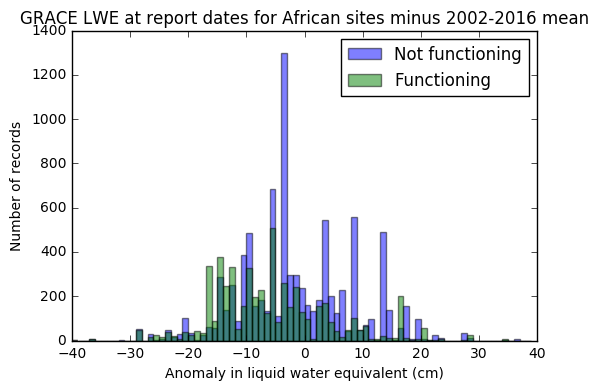

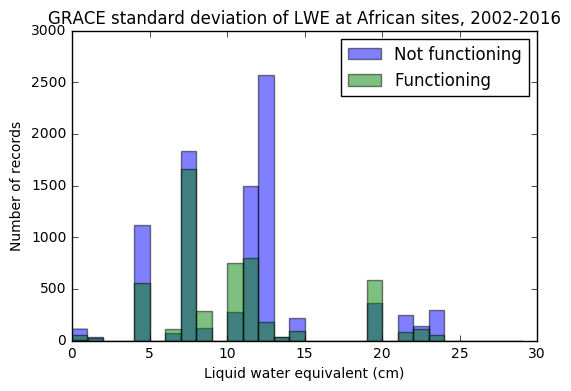

In [10]:
# Is there any relationship between GRACE and the well data?

# 1. Compare g_mean to g_rpt. Make 2 histograms, one for working and one for not. Anything there?


# differences between mean and report time GRACE values
d_mean_rpt_yes = wg[wg['FUNC']=='Yes' ]['grace_at_rpt_date']-wg[wg['FUNC']=='Yes']['grace_mean']
d_mean_rpt_no  = wg[wg['FUNC']=='No'  ]['grace_at_rpt_date']-wg[wg['FUNC']=='No' ]['grace_mean']

bins = np.arange(-40,40)

plt.hist(d_mean_rpt_yes,bins=bins,alpha=0.5,label='Not functioning')
plt.hist(d_mean_rpt_no ,bins=bins,alpha=0.5,label='Functioning')
plt.ylabel('Number of records')
plt.title('GRACE LWE at report dates for African sites minus 2002-2016 mean',size=12)
plt.legend(loc='upper right')
plt.xlabel('Anomaly in liquid water equivalent (cm)')
plt.show()

# 2. Histograms of g_std for working and not. Any difference?

d_std_yes = wg[wg['FUNC']=='Yes' ]['grace_std']
d_std_no  = wg[wg['FUNC']=='No'  ]['grace_std']

bins = np.arange(0,30)

plt.hist(d_std_yes,bins=bins,alpha=0.5,label='Not functioning')
plt.hist(d_std_no ,bins=bins,alpha=0.5,label='Functioning')
plt.ylabel('Number of records')
plt.title('GRACE standard deviation of LWE at African sites, 2002-2016')
plt.legend(loc='upper right')
plt.xlabel('Liquid water equivalent (cm)')
plt.show()

